In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
sns.set(style="darkgrid")


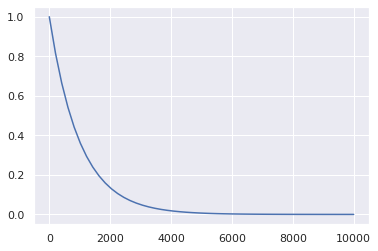

In [2]:
x = np.linspace(0, 10000)
plt.plot(x, 0.999**x)

In [4]:
def process_data(env_path):
    data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))
        data_set = np.stack(data_set)
        if data_set[-1,0] < min_size:
            min_size = data_set[-1,0]
        data.append(data_set)
    x_samples = np.linspace(0, min_size)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
        _y = data_set[:,1]
        interp_data.append(np.interp(x_samples, _x, _y))
    
#     data = np.stack([d[:min_size] for d in data])
    mean = np.median(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               '-std' : mean-std,
               '+std' : mean+std}
    return data_log

def plot_data(log, label):
    plt.plot(log['x'], log['mean'], label=label)
    plt.fill_between(log['x'], 
                    log['-std'], log['max'],
                    alpha=0.2)


In [129]:

hddpg_data = process_data('./benchmarks/data/PendulumEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/PendulumEnv/ddpg/')

hsac_data = process_data('./benchmarks/data/PendulumEnv/h_sac/')
sac_data = process_data('./benchmarks/data/PendulumEnv/sac/')

plot_data(hddpg_data, 'H-DDPG')

plot_data(hsac_data, 'H-SAC')

plot_data(ddpg_data, 'DDPG')
plot_data(sac_data, 'SAC')


plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()



FileNotFoundError: [Errno 2] No such file or directory: './benchmarks/data/PendulumEnv/h_ddpg/2019-12-26_00-12-38/reward_data.pkl'

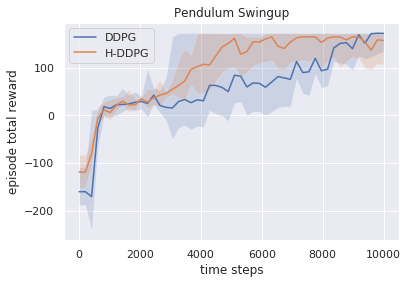

In [138]:
hddpg_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/ddpg/')

hsac_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/h_sac/')
sac_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/sac/')

plot_data(ddpg_data, 'DDPG')
plot_data(hddpg_data, 'H-DDPG')

# plot_data(sac_data, 'SAC')
# plot_data(hsac_data, 'H-SAC')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()

(-400, 200)

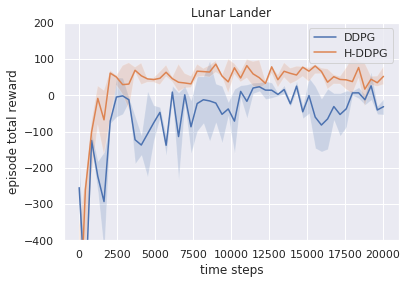

In [5]:
hddpg_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/ddpg/')

hsac_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/h_sac/')
# hsac_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/h_ddpg/')

sac_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/sac/')

plot_data(ddpg_data, 'DDPG')
plot_data(hddpg_data, 'H-DDPG')

# plot_data(sac_data, 'SAC')
# plot_data(hsac_data, 'H-SAC')


plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Lunar Lander')

plt.legend()
plt.ylim(-400, 200)

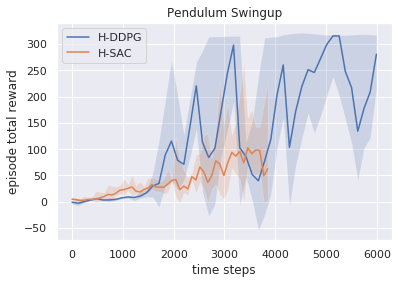

In [17]:
hsac_data = process_data('./benchmarks/data/HopperBulletEnv/h_sac/')
sac_data = process_data('./benchmarks/data/HopperBulletEnv/sac/')
hddpg_data = process_data('./benchmarks/data/HopperBulletEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/HopperBulletEnv/ddpg/')

# plot_data(ddpg_data, 'DDPG')
plot_data(hddpg_data, 'H-DDPG')

# plot_data(sac_data, 'SAC')

plot_data(hsac_data, 'H-SAC')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()


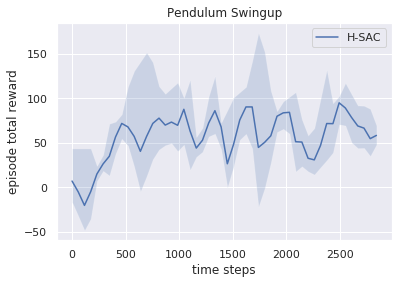

In [194]:
hsac_data = process_data('./benchmarks/data/KukaEnv/h_sac/')
# sac_data = process_data('./benchmarks/data/HopperBulletEnv/sac/')

# plot_data(ddpg_data, 'DDPG')
# plot_data(hddpg_data, 'H-DDPG')

# plot_data(sac_data, 'SAC')
plot_data(hsac_data, 'H-SAC')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()